In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer


In [2]:
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [3]:
con = sqlite3.connect(r"C:\Users\DELL\Desktop\database.sqlite")

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


# Exploratory data analysis

# Data Cleaning:Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. 
Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  
Following is an example:

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.



In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions


In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

# Preprocessing:text review

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1:Begin by removing the html tags
2:Remove any punctuations or limited set of special characters like , or . or # etc.
3:Check if the word is made up of english letters and is not alpha-numeric
4:Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5:Convert the word to lowercase
6:Remove Stopwords
7:Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
8:After which we collect the words used to describe positive and negative reviews

In [13]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [14]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [15]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [18]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [20]:
 #https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [21]:
# Combining all the above stundents 
preprocessed_reviews = []
for sentance in final['Text'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [22]:
final["CleanedText"]=preprocessed_reviews


# 4:Featurization

# 4.1:Bag of words

In [23]:
X=final["CleanedText"].values
y=final["Score"]

In [24]:
# from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [25]:
# split the data set into train and test

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)



In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
uni_gram=CountVectorizer()

In [28]:
count_vect=uni_gram.fit(X_tr)

In [29]:
X_tr=count_vect.transform(X_tr)
X_cv=count_vect.transform(X_cv)
X_test=count_vect.transform(X_test)


In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
scaler=StandardScaler(with_mean=False).fit(X_tr)
X_tr=scaler.transform(X_tr)
X_cv=scaler.transform(X_cv)
X_test=scaler.transform(X_test)

# HyperparameterTuning :finding best lambda/c^-1

# 4.1.1 L2 Regularizer

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [33]:
param=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001] 
from sklearn.metrics import roc_auc_score


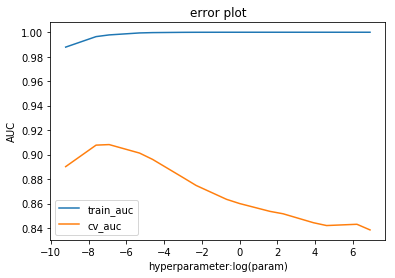

In [34]:
train_auc=[]
cv_auc=[]
for i in param:
    lr=LogisticRegression(penalty="l2",C=i)
    lr.fit(X_tr,y_tr)
    y_tr_predict=lr.predict_proba(X_tr)[:,1]
    y_cv_predict=lr.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(param), train_auc,label="train_auc")
plt.plot(np.log(param), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(param)")
plt.ylabel("AUC")
plt.legend()
plt.title("error plot")
plt.show()


In [35]:
optimal_C_bow=param[cv_auc.index(max(cv_auc))]
print(optimal_C_bow)

0.001


In [36]:
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],"penalty":["l2"]} 

In [37]:
model_bow_l2 = GridSearchCV(LogisticRegression(), param, scoring = 'roc_auc', cv=5)
model_bow_l2.fit(X_tr,y_tr)

print(model_bow_l2.best_estimator_)
print(model_bow_l2.score(X_cv, y_cv))

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9081606544753892


In [38]:
model_bow_l2_optimal_C=model_bow_l2.best_estimator_.C

# testing accuracy on test data

In [39]:
#===============================training model at optimal C===================================================================#
model_bow_l2=LogisticRegression(C=0.001,penalty="l2")
model_bow_l2.fit(X_tr,y_tr)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
from sklearn.metrics import accuracy_score,confusion_matrix

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



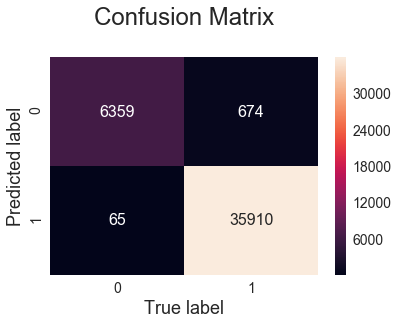

98.28171502976191


In [41]:
#confusion matrix on train data
y_pred_tr = model_bow_l2.predict(X_tr)
acc_tr_bow_l2=accuracy_score(y_tr, y_pred_tr)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_tr, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_tr_bow_l2)

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



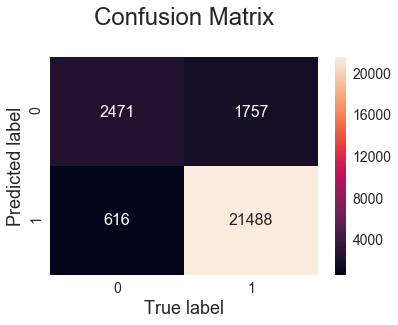

90.98815129879993


In [42]:
y_pred_test = model_bow_l2.predict(X_test)
acc_test_bow_l2=accuracy_score(y_test, y_pred_test)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_test_bow_l2)

# 4.1.2 l1 regularizer

In [43]:
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],"penalty":["l1"]} 

In [44]:
model_bow_l1=GridSearchCV(LogisticRegression(),param,scoring="roc_auc",cv=5)
model_bow_l1.fit(X_tr,y_tr)

print(model_bow_l1.best_estimator_)
print(model_bow_l1.score(X_cv,y_cv))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9330207033605928


In [45]:
model_bow_l1_optimal_C=model_bow_l1.best_estimator_.C

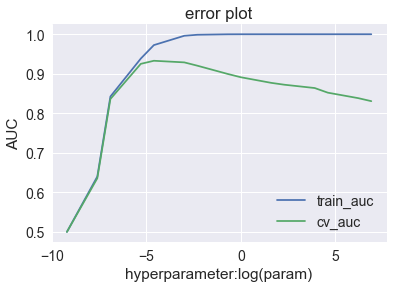

In [46]:
# roc auc plot
param=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001] 

train_auc=[]
cv_auc=[]
for i in param:
    lr=LogisticRegression(penalty="l1",C=i)
    lr.fit(X_tr,y_tr)
    y_tr_predict=lr.predict_proba(X_tr)[:,1]
    y_cv_predict=lr.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(param), train_auc,label="train_auc")
plt.plot(np.log(param), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(param)")
plt.ylabel("AUC")
plt.legend()
plt.title("error plot")
plt.show()



In [47]:
optimal_C_bow_l1=param[cv_auc.index(max(cv_auc))]
print(optimal_C_bow_l1)

0.01


# testing accuracy on test data

In [48]:
model_bow_l1=LogisticRegression(C=0.01,penalty="l1")
model_bow_l1.fit(X_tr,y_tr)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



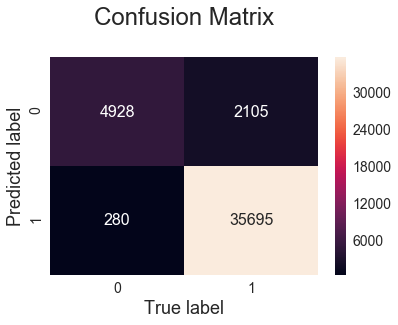

94.45452008928571


In [49]:
#cofusion matrix for trai data 
y_pred_tr=model_bow_l1.predict(X_tr)
acc_tr_bow_l1=accuracy_score(y_tr,y_pred_tr)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_tr, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_tr_bow_l1)


Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



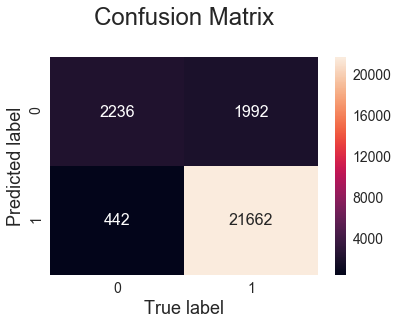

90.75649399969619


In [50]:
#confusion matrix for test data 
y_pred_test=model_bow_l1.predict(X_test)
acc_test_bow_l1=accuracy_score(y_test,y_pred_test)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_test_bow_l1)


Conclusion:Accuracy on l2 is better than l1

# change in sparsity with change in lambda/c^-1


# @ c=100

In [51]:
model_bow_l1=LogisticRegression(C=100,penalty="l1")
model_bow_l1.fit(X_tr,y_tr)
y_pred_test=model_bow_l1.predict(X_test)
acc=accuracy_score(y_test,y_pred_test)
w=model_bow_l1.coef_
print(np.count_nonzero(w))
print(acc)

14070
0.8659425793711074


# @C =50

In [52]:
model_bow_l1=LogisticRegression(C=50,penalty="l1")
model_bow_l1.fit(X_tr,y_tr)
y_pred=model_bow_l1.predict(X_test)
acc=accuracy_score(y_test,y_pred)
w=model_bow_l1.coef_
print(np.count_nonzero(w))
print(acc)

10782
0.871297280874981


# @ C= 10

In [53]:
model_bow_l1=LogisticRegression(C=10,penalty="l1")
model_bow_l1.fit(X_tr,y_tr)
y_pred=model_bow_l1.predict(X_test)
acc=accuracy_score(y_test,y_pred)
w=model_bow_l1.coef_
print(np.count_nonzero(w))
print(acc)

10928
0.8761962631019292


# @ C=1

In [54]:
model_bow_l1=LogisticRegression(C=1,penalty="l1")
model_bow_l1.fit(X_tr,y_tr)
y_pred=model_bow_l1.predict(X_test)
acc=accuracy_score(y_test,y_pred)
w=model_bow_l1.coef_
print(np.count_nonzero(w))
print(acc)

10109
0.8901336776545647


# @ C=0.1

In [55]:
model_bow_l1=LogisticRegression(C=0.1,penalty="l1")
model_bow_l1.fit(X_tr,y_tr)
y_pred=model_bow_l1.predict(X_test)
acc=accuracy_score(y_test,y_pred)
w=model_bow_l1.coef_
print(np.count_nonzero(w))
print(acc)

8766
0.9076408932097828


# @ C=0.05

In [56]:
model_bow_l1=LogisticRegression(C=0.05,penalty="l1")
model_bow_l1.fit(X_tr,y_tr)
y_pred=model_bow_l1.predict(X_test)
acc=accuracy_score(y_test,y_pred)
w=model_bow_l1.coef_
print(np.count_nonzero(w))
print(acc)

7492
0.911362600638007


# @ C=0.01

In [57]:
model_bow_l1=LogisticRegression(C=0.01,penalty="l1")
model_bow_l1.fit(X_tr,y_tr)
y_pred=model_bow_l1.predict(X_test)
acc=accuracy_score(y_test,y_pred)
w=model_bow_l1.coef_
print(np.count_nonzero(w))
print(acc)

3024
0.9074510101777306


# @ C=0.001

In [58]:
model=LogisticRegression(C=0.001,penalty="l1")
model.fit(X_tr,y_tr)
y_pred=model.predict(X_test)
acc=accuracy_score(y_test,y_pred)*100
w=model.coef_
print(np.count_nonzero(w))
print(acc)

38
85.05620537748747


# conclusion

we can see clearly , as lambda increases number of non zero weight vector decreases drastically 
or sparsity increases

# Pertubation Test

In [59]:
clf_bow=LogisticRegression(C=0.001,penalty="l2")
clf_bow.fit(X_tr,y_tr)
y_pred=clf_bow.predict(X_test)
print("Non zero wrights:",np.count_nonzero(clf_bow.coef_))

Non zero wrights: 39330


# weights before adding noise

In [60]:
from scipy.sparse import find
w_1 = find(clf_bow.coef_)[2]
print(w_1[:50])
# find returns row indices , column indices and values of non_zero elements in a sparse matrix
# find(csr_matrix)[2] returns non_zero elements of matrix

[ 7.50950852e-03  6.29607479e-03  6.52460722e-03  1.85936207e-03
  1.43573028e-03  9.02022822e-04  1.15206558e-04 -7.67553845e-03
  1.15206558e-04  1.23508525e-03 -1.08496918e-08  2.83126701e-05
 -5.69367636e-03  5.51024911e-04  6.59055082e-03 -2.01001484e-03
  2.50924878e-05 -1.37071594e-03 -1.19560646e-02  7.05350294e-04
  1.28156883e-02  1.24812934e-02 -1.87064686e-02  9.15042013e-04
  2.46985103e-08 -1.20133357e-11  5.80839156e-05  8.50480327e-03
 -4.44594461e-03  1.07515411e-03 -6.03121522e-03 -1.67386467e-03
  2.24073523e-03 -1.52856450e-03  8.91135348e-03  1.93056782e-04
  3.50086797e-03  1.63084290e-08  7.05312305e-04  2.22811264e-04
  4.11153264e-05  5.54591146e-03 -3.20236052e-03  9.73066763e-04
  3.90239287e-03 -5.44118852e-08  4.36503659e-02  5.79960551e-04
 -5.43814195e-03 -3.43887836e-03]


In [61]:
X_tr_n=X_tr
type(X_tr_n)

scipy.sparse.csr.csr_matrix

In [62]:
#random noise
epsilon=np.random.uniform(low=-0.0001,high=0.0001,size=find(X_tr_n)[0].size)
#position 
# a:row ,b: column ,c: value of non zero datapoints
a,b,c=find(X_tr_n)
X_tr_n[a,b]+=epsilon

In [63]:
#training with noise data
clf_bow_n=LogisticRegression(C=0.001,penalty="l2")
clf_bow_n.fit(X_tr_n,y_tr)
y_pred=clf_bow_n.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non zero wrights:",np.count_nonzero(clf_bow.coef_))

Accuracy on test set: 90.988%
Non zero wrights: 39330


In [64]:
w_2=find(clf_bow_n.coef_[0])[2]
print(w_2[:50])

[ 7.50952113e-03  6.29604984e-03  6.52454028e-03  1.85944867e-03
  1.43569785e-03  9.01989381e-04  1.15144821e-04 -7.67595859e-03
  1.15144868e-04  1.23503145e-03 -5.36633509e-08  2.83114471e-05
 -5.69370201e-03  5.51018548e-04  6.59043556e-03 -2.00982299e-03
  2.50733129e-05 -1.37067536e-03 -1.19560650e-02  7.04984602e-04
  1.28155477e-02  1.24815181e-02 -1.87073143e-02  9.15095395e-04
  1.03420605e-08 -2.90093390e-09  5.80932207e-05  8.50470172e-03
 -4.44604637e-03  1.07513548e-03 -6.03103881e-03 -1.67384371e-03
  2.24097174e-03 -1.52815143e-03  8.91142273e-03  1.93065618e-04
  3.50082352e-03  1.70994217e-08  7.05295169e-04  2.22856927e-04
  4.11110429e-05  5.54597078e-03 -3.20173426e-03  9.73025827e-04
  3.90249580e-03 -8.92950653e-08  4.36499844e-02  5.79669717e-04
 -5.43984813e-03 -3.43829214e-03]


In [65]:
w_1=w_1+10**-6
w_2=w_2+10**-6

In [66]:
w_diff = (abs(w_1 - w_2)/w_1) * 100
shorted_w_diff=np.sort(w_diff)[:-1]
shorted_w_diff[0:10]

array([-73242.57855777, -73242.53226789, -73242.4983552 , -73242.48907759,
       -73242.4781589 , -73242.47230193,   -244.1551665 ,   -244.15508243,
         -244.15491399,   -244.15481684])

Conclusion : highest change of percentahe is 2.72%

In [67]:
# Change in vectors after adding epsilon
change_vector = abs(w_1-w_2)
# Sort this change_vector array after making all the elements positive in descending order to visualize the change
sorted_change_vector = np.sort(change_vector)[:-1]

sorted_change_vector[0:10]

array([2.21693497e-12, 3.07808694e-12, 3.66299439e-12, 6.90025668e-12,
       9.16518429e-12, 1.26085310e-11, 1.32957886e-11, 1.45477058e-11,
       1.53518872e-11, 1.69273181e-11])

In [68]:
print(w_diff[np.where(w_diff > 1)].size)

799


In [69]:
print(w_diff[np.where(w_diff > 1.2)].size)

666


In [70]:
print(w_diff[np.where(w_diff > 1.3)].size)

601


In [71]:
print(w_diff[np.where(w_diff > 1.4)].size)

556


In [72]:
print(w_diff[np.where(w_diff > 1.5)].size)

514


In [73]:
print(w_diff[np.where(w_diff > 2)].size)

368


In [74]:
print(w_1[np.where(w_diff > 2.5)].size)

288


# Percentile of changed weight vector

In [75]:
type(w_diff)


numpy.ndarray

In [76]:
#percentile of 0:100 with step of 10; 0,10,30,40...100
percentile=[]
for i in range(0,100,10):
    percentile.append(np.percentile(w_diff,i))
    
percentile
    

[-73242.5785577702,
 -0.005077230045798998,
 -0.0013636891913614562,
 0.00010303425349565457,
 0.0006292134676706692,
 0.0012556309314953572,
 0.0020818474050986564,
 0.003361949116759947,
 0.0060795773478632565,
 0.023132398432967962]

In [77]:
range_=[0.1,0.2,0.3,0.4,0.5]
#percentile of 0:1 with step of 0.1; 0.1,0.20,0.30,0.40...0.5
percentile=[]
for i in range_:
    percentile.append(np.percentile(w_diff,i))
    
percentile
    

[-33.32087882392589,
 -3.6534585104313297,
 -0.524774236203442,
 -0.4003382289773679,
 -0.23938133002924905]

In [78]:
range_=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]
#percentile of 0:0.1 with step of 0.01; 00.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.08,0.09,0.10
percentile=[]
for i in range_:
    percentile.append(np.percentile(w_diff,i))
    
percentile
    

[-73242.47889154356,
 -244.15493659533044,
 -116.43668224440779,
 -114.39905020079465,
 -80.99443170081202,
 -49.604809841268846,
 -49.60476466375208,
 -49.6047373952552,
 -49.6046472151512,
 -33.32087882392589]

Conclusion:a lot of data point(percentage of change weight vector) lie in between 0 to 0.1 percentage

In [79]:
#percentile of 0:10 with step of 1; 0,1,3,4...10
percentile=[]
for i in range(0,10,1):
    percentile.append(np.percentile(w_diff,i))
    
percentile
    

[-73242.5785577702,
 -0.09676146140581085,
 -0.0360183316176514,
 -0.02107483289051871,
 -0.015162418456480628,
 -0.011895310152698629,
 -0.009462232664039304,
 -0.007715937649873635,
 -0.006556915136833793,
 -0.0057202120661675685]

In [165]:
#feature names with changed weight 
feature_names = count_vect.get_feature_names()
coefs_feature_names = sorted(zip(w_1[np.where(w_diff>0.1)], feature_names))
top=coefs_feature_names[:10]
for coef in top:
    print(coef)


(3.2023900177252607e-08, 'adem')
(1.6258613208109517e-07, 'arizona')
(3.4942021906257685e-07, 'al')
(3.581777801008127e-07, 'agreeing')
(3.581777801008127e-07, 'anomaly')
(3.581777801008127e-07, 'attache')
(3.581777801008127e-07, 'automotive')
(4.98949047853807e-07, 'absoluteley')
(4.98949047853807e-07, 'adopter')
(4.98949047853807e-07, 'ammish')


# Top 10 features

In [81]:
model_bow_l2.classes_

array([0, 1], dtype=int64)

In [82]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_feature_names = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_feature_names[:n], coefs_feature_names[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))


In [83]:
show_most_informative_features(count_vect,model_bow_l2)

	-0.2374	not            		0.3750	great          
	-0.1560	disappointed   		0.2565	best           
	-0.1456	worst          		0.2549	love           
	-0.1311	horrible       		0.2530	good           
	-0.1290	terrible       		0.2143	delicious      
	-0.1194	disappointment 		0.1790	loves          
	-0.1191	disappointing  		0.1674	excellent      
	-0.1158	awful          		0.1654	perfect        
	-0.1139	bad            		0.1623	nice           
	-0.1098	stale          		0.1550	favorite       


# 4.2 TFIDF

In [84]:
X=final["CleanedText"].values
y=final["Score"]

In [85]:
# split the data set into train and test

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)


In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [87]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf_vect=tf_idf_vect.fit(X_tr)


In [88]:
X_tr=tfidf_vect.transform(X_tr)
X_test=tfidf_vect.transform(X_test)
X_cv=tfidf_vect.transform(X_cv)

In [89]:
scaler=StandardScaler(with_mean=False).fit(X_tr)
X_tr=scaler.transform(X_tr)
X_cv=scaler.transform(X_cv)
X_test=scaler.transform(X_test)

# 4.2.1 l2 regularizer

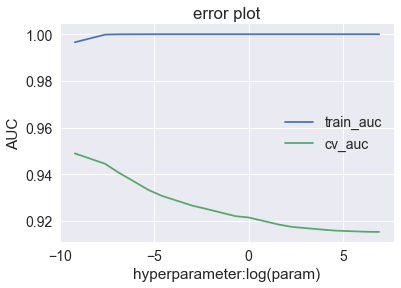

In [90]:
param=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
train_auc=[]
cv_auc=[]
for i in param:
    lr=LogisticRegression(penalty="l2",C=i)
    lr.fit(X_tr,y_tr)
    y_tr_predict=lr.predict_proba(X_tr)[:,1]
    y_cv_predict=lr.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(param), train_auc,label="train_auc")
plt.plot(np.log(param), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(param)")
plt.ylabel("AUC")
plt.legend()
plt.title("error plot")
plt.show()

In [91]:
optimal_C_tfidf_l2=param[cv_auc.index(max(cv_auc))]
print(optimal_C_tfidf_l2)

0.0001


In [92]:
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],"penalty":["l2"]} 

In [93]:
model_tfidf_l2 = GridSearchCV(LogisticRegression(), param, scoring = 'roc_auc', cv=5)
model_tfidf_l2.fit(X_tr, y_tr)

print(model_tfidf_l2.best_estimator_)
print(model_tfidf_l2.score(X_cv, y_cv))

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.9489643864576627


In [94]:
model_tfidf_l2_optimal_c=model_tfidf_l2.best_estimator_.C

In [95]:
#===============================training model at optimal C========================================================#
model_tfidf_l2=LogisticRegression(C=0.001,penalty="l2")
model_tfidf_l2.fit(X_tr,y_tr)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



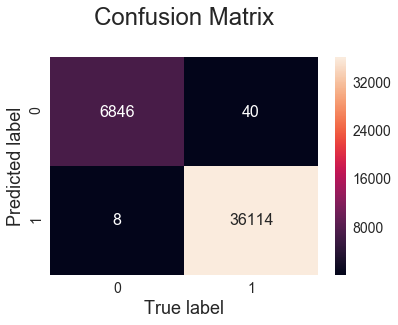

99.88839285714286


In [96]:
#confusion  matrix for train data 
y_pred_tr = model_tfidf_l2.predict(X_tr)
acc_tr_tfidf_l2=accuracy_score(y_tr, y_pred_tr)*100

print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_tr, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_tr_tfidf_l2)

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



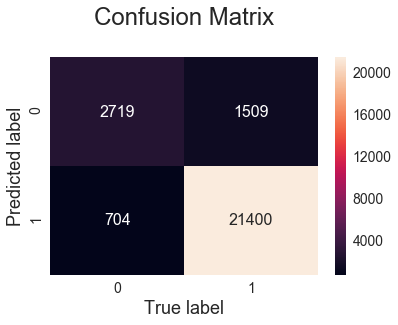

91.59577700136717


In [97]:
#confusion  matrix for train data 
y_pred_test = model_tfidf_l2.predict(X_test)
acc_test_tfidf_l2=accuracy_score(y_test, y_pred_test)*100

print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_test_tfidf_l2)

# 4.2.2 l1 regularizer

In [98]:
param=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

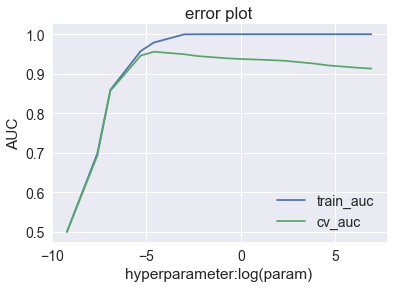

In [99]:
train_auc=[]
cv_auc=[]
for i in param:
    lr=LogisticRegression(penalty="l1",C=i)
    lr.fit(X_tr,y_tr)
    y_tr_predict=lr.predict_proba(X_tr)[:,1]
    y_cv_predict=lr.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(param), train_auc,label="train_auc")
plt.plot(np.log(param), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(param)")
plt.ylabel("AUC")
plt.legend()
plt.title("error plot")
plt.show()

In [100]:
optimal_C_tfidf_l1=param[cv_auc.index(max(cv_auc))]
print(optimal_C_tfidf_l1)

0.01


In [101]:
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],"penalty":["l1"]} 

In [102]:
model_tfidf_l1 = GridSearchCV(LogisticRegression(), param, scoring = 'roc_auc', cv=5)
model_tfidf_l1.fit(X_tr, y_tr)

print(model_tfidf_l1.best_estimator_)
print(model_tfidf_l1.score(X_cv, y_cv))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9557354299256389


In [103]:
model_tfidf_l1_optimal_C=model_tfidf_l1.best_estimator_.C

In [104]:
model_tfidf_l1=LogisticRegression(C=0.01,penalty="l1")
model_tfidf_l1.fit(X_tr,y_tr)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# testing accuracy

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



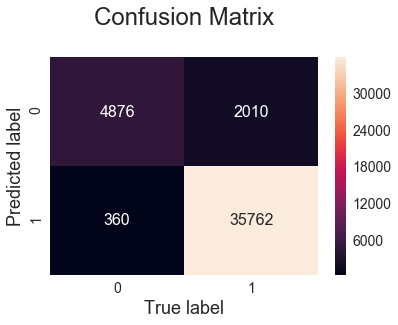

94.48939732142857


In [105]:
#confusion matrix for train data 
y_pred_tr = model_tfidf_l1.predict(X_tr)
acc_tr_tfidf_l1=accuracy_score(y_tr, y_pred_tr)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_tr, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_tr_tfidf_l1)

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



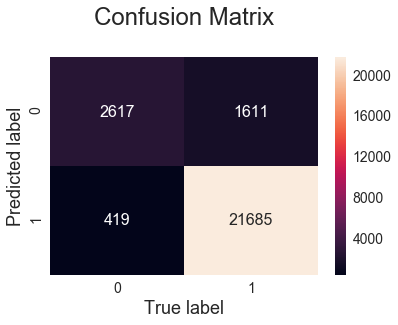

92.29074889867842


In [106]:
#confusion matrix on test data 
y_pred_test = model_tfidf_l1.predict(X_test)
acc_test_tfidf_l1=accuracy_score(y_test, y_pred_test)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_test_tfidf_l1)

conclusion: Accuracy on l1 is better than l2





# top ten features

In [107]:
show_most_informative_features(tfidf_vect,model_tfidf_l2)

	-0.1114	disappointed   		0.2085	great          
	-0.1037	not worth      		0.1615	love           
	-0.1035	worst          		0.1553	good           
	-0.1018	not good       		0.1467	best           
	-0.1010	not buy        		0.1291	delicious      
	-0.0965	not recommend  		0.1131	loves          
	-0.0888	disappointing  		0.1062	perfect        
	-0.0874	awful          		0.1009	nice           
	-0.0813	terrible       		0.0972	favorite       
	-0.0794	disappointment 		0.0898	wonderful      


# 4.3 avg w2vect

In [108]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [109]:
# split the data set into train and test

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)


In [110]:
# training our own word to vec
list_of_sent_tr=[]
for sent in X_tr:
    list_of_sent_tr.append(sent.split())
    
list_of_sent_cv=[]
for sent in X_cv:
    list_of_sent_cv.append(sent.split())
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())

In [111]:
w2v_model=Word2Vec(list_of_sent_tr,min_count=5,size=50, workers=4)

In [112]:
w2v_words = list(w2v_model.wv.vocab)

In [113]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

43008
50


In [114]:
X_tr=sent_vectors_tr

In [115]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

18433
50


In [116]:
X_cv=sent_vectors_cv

In [117]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

26332
50


In [118]:
X_test=sent_vectors_test

In [119]:
scaler=StandardScaler(with_mean=False).fit(X_tr)

In [120]:
X_tr=scaler.transform(X_tr)
X_cv=scaler.transform(X_cv)
X_test=scaler.transform(X_test)

# 4.3.1 l2 regularizer

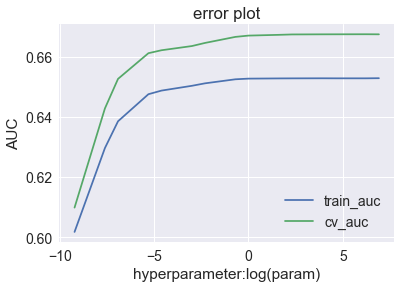

In [121]:
param=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
train_auc=[]
cv_auc=[]
for i in param:
    lr=LogisticRegression(penalty="l2",C=i)
    lr.fit(X_tr,y_tr)
    y_tr_predict=lr.predict_proba(X_tr)[:,1]
    y_cv_predict=lr.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(param), train_auc,label="train_auc")
plt.plot(np.log(param), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(param)")
plt.ylabel("AUC")
plt.legend()
plt.title("error plot")
plt.show()

In [122]:
optimal_C_avgw2vec_l2=param[cv_auc.index(max(cv_auc))]
print(optimal_C_avgw2vec_l2)

500


In [123]:
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],"penalty":["l2"]} 

In [124]:
model_avgw2vec_l2 = GridSearchCV(LogisticRegression(), param, scoring = 'roc_auc', cv=5)
model_avgw2vec_l2.fit(X_tr, y_tr)

print(model_avgw2vec_l2.best_estimator_)
print(model_avgw2vec_l2.score(X_cv, y_cv))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.6674545505780288


In [125]:
model_avgw2vec_l2_optimal_C=model_avgw2vec_l2.best_estimator_.C

In [126]:
model_avgw2vec_l2=LogisticRegression(C=model_avgw2vec_l2_optimal_C,penalty="l2")
model_avgw2vec_l2.fit(X_tr,y_tr)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# testing acc

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



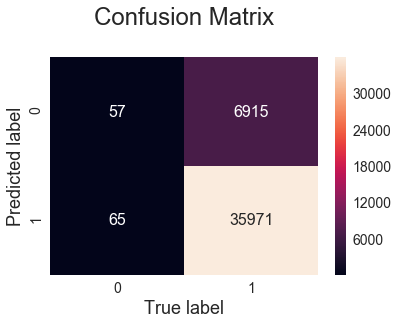

83.77046130952381


In [127]:
y_pred_tr = model_avgw2vec_l2.predict(X_tr)
acc_tr_avgw2vec_l2=accuracy_score(y_tr, y_pred_tr)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_tr, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_tr_avgw2vec_l2)

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



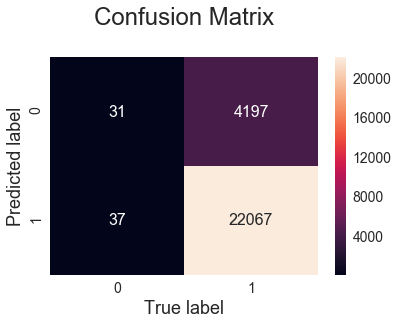

83.92070484581498


In [128]:
#cofusion matrix on test data 
y_pred_test = model_avgw2vec_l2.predict(X_test)
acc_test_avgw2vec_l2=accuracy_score(y_test, y_pred_test)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_test_avgw2vec_l2)

# l1

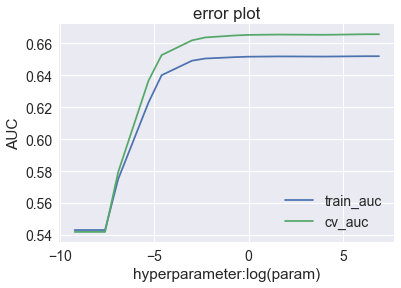

500


In [129]:
param=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
train_auc=[]
cv_auc=[]
for i in param:
    lr=LogisticRegression(penalty="l1",C=i)
    lr.fit(X_tr,y_tr)
    y_tr_predict=lr.predict_proba(X_tr)[:,1]
    y_cv_predict=lr.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(param), train_auc,label="train_auc")
plt.plot(np.log(param), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(param)")
plt.ylabel("AUC")
plt.legend()
plt.title("error plot")
plt.show()

optimal_C_avgw2vec_l1=param[cv_auc.index(max(cv_auc))]
print(optimal_C_avgw2vec_l1)

In [130]:
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],"penalty":["l1"]} 

In [131]:
model_avgw2vec_l1 = GridSearchCV(LogisticRegression(), param, scoring = 'roc_auc', cv=5)
model_avgw2vec_l1.fit(X_tr, y_tr)

print(model_avgw2vec_l1.best_estimator_)
print(model_avgw2vec_l1.score(X_cv, y_cv))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.6652874256780127


In [132]:
model_avgw2vec_l1_optimal_C=model_avgw2vec_l1.best_estimator_.C

In [133]:
model_avgw2vec_l1=LogisticRegression(C=model_avgw2vec_l1_optimal_C,penalty="l1")
model_avgw2vec_l1.fit(X_tr,y_tr)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



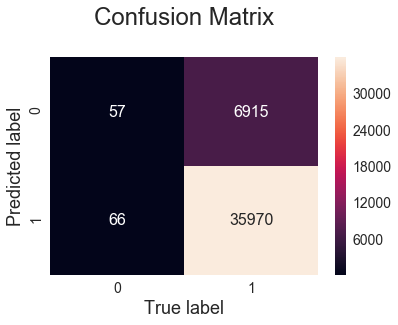

83.76813616071429


In [134]:
#confusion matrix on train data 
y_pred_tr = model_avgw2vec_l1.predict(X_tr)
acc_tr_avgw2vec_l1=accuracy_score(y_tr, y_pred_tr)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_tr, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_tr_avgw2vec_l1)




Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



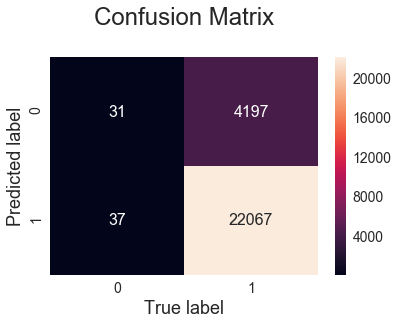

83.92070484581498


In [135]:
#confusion matrix on test data 
y_pred_test = model_avgw2vec_l1.predict(X_test)
acc_test_avgw2vec_l1=accuracy_score(y_test, y_pred_test)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_test_avgw2vec_l1)



# 4.4 tfidf w2vec

In [136]:
X=final["CleanedText"].values
y=final["Score"]

In [137]:
X_1,X_test,y_1,y_test=train_test_split(X,y,test_size=0.3,random_state=2)
X_tr,X_cv,y_tr,y_cv=train_test_split(X_1,y_1)

In [138]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [139]:
i=0
list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())

In [140]:
w2v_model=Word2Vec(list_of_sentance_tr,min_count=5,size=50, workers=4)

In [141]:
w2v_words = list(w2v_model.wv.vocab)

In [142]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sentance_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_tr: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #       tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sentance_vectors_tr.append(sent_vec)
    row += 1

In [143]:
X_tr=tfidf_sentance_vectors_tr

In [144]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [145]:
tfidf_sentance_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sentance_vectors_cv.append(sent_vec)
    row += 1

In [146]:
X_cv=tfidf_sentance_vectors_cv

In [147]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [148]:
tfidf_sentance_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sentance_vectors_test.append(sent_vec)
    row += 1

In [149]:
X_test=tfidf_sentance_vectors_test

# 4.4.2 L2 regularizer

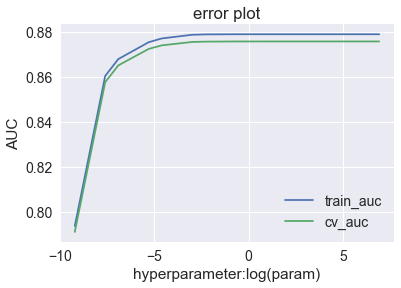

1000


In [150]:
param=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
train_auc=[]
cv_auc=[]
for i in param:
    lr=LogisticRegression(penalty="l2",C=i)
    lr.fit(X_tr,y_tr)
    y_tr_predict=lr.predict_proba(X_tr)[:,1]
    y_cv_predict=lr.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(param), train_auc,label="train_auc")
plt.plot(np.log(param), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(param)")
plt.ylabel("AUC")
plt.legend()
plt.title("error plot")
plt.show()

optimal_C_tfidfw2vec_l2=param[cv_auc.index(max(cv_auc))]
print(optimal_C_tfidfw2vec_l2)

In [151]:
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],"penalty":["l2"]} 

In [152]:
model_tfidfw2vec_l2 = GridSearchCV(LogisticRegression(), param, scoring = 'roc_auc', cv=5)
model_tfidfw2vec_l2.fit(X_tr, y_tr)

print(model_tfidfw2vec_l2.best_estimator_)
print(model_tfidfw2vec_l2.score(X_cv, y_cv))

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.8756735138758218


In [153]:
model_tfidfw2vec_l2_optimal_C=model_tfidfw2vec_l2.best_estimator_.C

In [154]:
model_tfidfw2vec_l2=LogisticRegression(C=model_tfidfw2vec_l2_optimal_C,penalty="l2")
model_tfidfw2vec_l2.fit(X_tr,y_tr)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



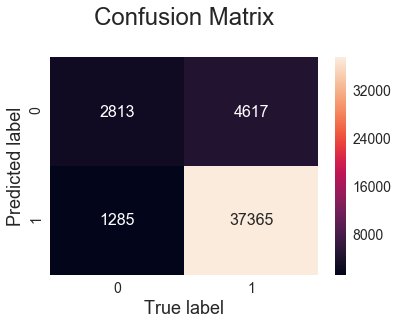

87.19184027777777


In [155]:
#confusion matrix on train data
y_pred_tr = model_tfidfw2vec_l2.predict(X_tr)
acc_tr_tfidfw2vec_l2=accuracy_score(y_tr, y_pred_tr)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_tr, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_tr_tfidfw2vec_l2)

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



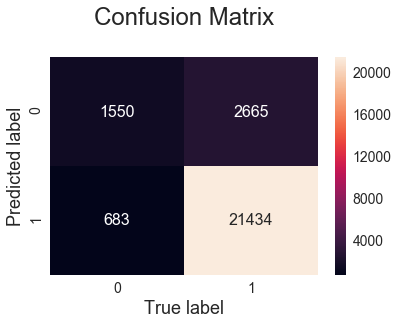

87.28543217378095


In [156]:
#confusion matrix on test data 
y_pred_test = model_tfidfw2vec_l2.predict(X_test)
acc_test_tfidfw2vec_l2=accuracy_score(y_test, y_pred_test)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_test_tfidfw2vec_l2)

# l1

In [158]:
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],"penalty":["l1"]} 

In [159]:
model_tfidfw2vec_l1 = GridSearchCV(LogisticRegression(), param, scoring = 'roc_auc', cv=5)
model_tfidfw2vec_l1.fit(X_tr, y_tr)

print(model_tfidfw2vec_l1.best_estimator_)
print(model_tfidfw2vec_l1.score(X_cv, y_cv))

LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.8756820921037258


In [160]:
model_tfidfw2vec_l1_optimal_C=model_tfidfw2vec_l1.best_estimator_.C

In [161]:
model_tfidfw2vec_l1=LogisticRegression(C=model_tfidfw2vec_l1_optimal_C,penalty="l1")
model_tfidfw2vec_l1.fit(X_tr,y_tr)

LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



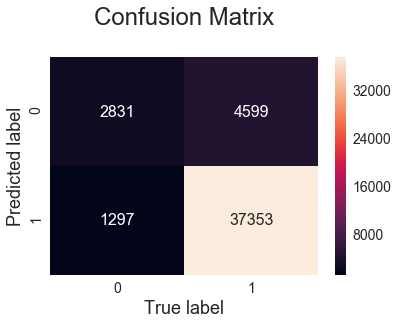

87.20486111111111


In [162]:
#accuracy on train data 
y_pred_tr = model_tfidfw2vec_l1.predict(X_tr)
acc_tr_tfidfw2vec_l1=accuracy_score(y_tr, y_pred_tr)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_tr, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_tr_tfidfw2vec_l1)

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



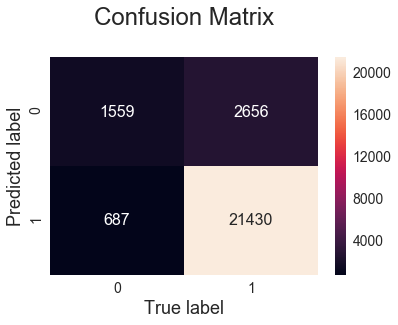

87.30442047698618


In [163]:
#accuracy on test data  
y_pred_test = model_tfidfw2vec_l1.predict(X_test)
acc_test_tfidfw2vec_l1=accuracy_score(y_test, y_pred_test)*100
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()
print(acc_test_tfidfw2vec_l1)

In [164]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['LR(l2|GridSearchCV) for BoW','LR(l1|GridSearchCV) for BoW',\
         'LR(l2|GridSearchCV) for TFIDF','LR(ll|GridSearchCV) for TFIDF',\
         'LR(l2|GridSearchCV) for Avg_Word2Vec','LR(l1|GridSearchCV) for Avg_Word2Vec',\
         'LR(l2|GridSearchCV) for tfidf_Word2Vec','LR(l1|GridSearchCV) for tfidf_Word2Vec']

# Optimal values of C i.e. (1/lambda)
optimal_C = [model_bow_l2_optimal_C,model_bow_l1_optimal_C,\
             model_tfidf_l2_optimal_c,model_tfidf_l1_optimal_C,\
             model_avgw2vec_l2_optimal_C,model_avgw2vec_l1_optimal_C,\
             model_tfidfw2vec_l2_optimal_C,model_tfidfw2vec_l1_optimal_C]

# Training accuracies
train_acc = [acc_tr_bow_l2,acc_tr_bow_l1,\
             acc_tr_tfidf_l2,acc_tr_tfidf_l1,\
             acc_tr_avgw2vec_l2,acc_tr_avgw2vec_l1,\
             acc_tr_tfidfw2vec_l2,acc_tr_tfidfw2vec_l1]

# Test accuracies
test_acc =[acc_test_bow_l2,acc_test_bow_l1,\
             acc_test_tfidf_l2,acc_test_tfidf_l1,\
             acc_test_avgw2vec_l2,acc_test_avgw2vec_l1,\
             acc_test_tfidfw2vec_l2,acc_test_tfidfw2vec_l1] 

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best C(1/lambda)",optimal_C)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)


# Printing note regarding information of "MODEL" column in the table
print("NOTE:- In the Table below in 'MODEL' column :")
print("\t LR(l2|GridSearchCV) : Logistic Regression with L2 regularisation as an estimator in GridSearchCV")
print("\t LR(l1|GridSearchCV) : Logistic Regression with L1 regularisation as an estimator in GridSearchCV")
# Printing the Table
print(ptable)

NOTE:- In the Table below in 'MODEL' column :
	 LR(l2|GridSearchCV) : Logistic Regression with L2 regularisation as an estimator in GridSearchCV
	 LR(l1|GridSearchCV) : Logistic Regression with L1 regularisation as an estimator in GridSearchCV
+-------+----------------------------------------+------------------+-------------------+-------------------+
| S.NO. |                 MODEL                  | Best C(1/lambda) | Training Accuracy |   Test Accuracy   |
+-------+----------------------------------------+------------------+-------------------+-------------------+
|   1   |      LR(l2|GridSearchCV) for BoW       |      0.001       | 98.28171502976191 | 90.98815129879993 |
|   2   |      LR(l1|GridSearchCV) for BoW       |       0.01       | 94.45452008928571 | 90.75649399969619 |
|   3   |     LR(l2|GridSearchCV) for TFIDF      |      0.0001      | 99.88839285714286 | 91.59577700136717 |
|   4   |     LR(ll|GridSearchCV) for TFIDF      |       0.01       | 94.48939732142857 | 92.290